In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from fig_params import fig_params

In [2]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()
def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print ("Toc: start time not set")
fig_params()

In [3]:
# constants
So = 1363
sigma = 5.67e-8
a = 0.3
Sw = So/4*(1-a)
g = 9.81
cp = 1004 #[J/kg/K]

In [4]:
# initialize arrays
plev = np.arange(105000,0,-5000) # pressure array
m = 5000/g # mass array 

# t = np.zeros(1_000_000) # time array
t = np.zeros(10*365*24); print(len(t))
T = np.zeros([np.size(plev),np.size(t)])
T_strat = np.zeros([np.size(plev),np.size(t)])
epsilon = np.zeros(np.size(plev))
f_down = np.zeros([np.size(plev),np.size(t)])
f_up = np.zeros([np.size(plev),np.size(t)])
# flux arrays for dF
lw_up_top = np.zeros([np.size(plev),np.size(t)]) # upward LW 
lw_up_bot = np.zeros([np.size(plev),np.size(t)]) # ---
lw_down_top = np.zeros([np.size(plev),np.size(t)]) # downloward LW
lw_down_bot = np.zeros([np.size(plev),np.size(t)]) # ---

sw_down_top = np.zeros([np.size(plev),np.size(t)]) # downward SW top array
sw_down_bot = np.zeros([np.size(plev),np.size(t)]) # downward SW bot array 
dF = np.zeros([np.size(plev),np.size(t)]) # net radiative flux of layer


# initial conditions
T[:,0] = 50 # set all layers 50 Kelvin
T_strat[:,0] = 50 # --- #

# set piecewise epsilon array vals  
mask = plev>80000
epsilon[mask] = 0.3
mask = (plev<=80000) & (plev>40000)
epsilon[mask] = 0.2
mask = plev<=40000
epsilon[mask] = 0.1
epsilon[0] = 1 # surface epsilon 

87600


###  Part a) Radiative Equilibrium with only a troposphere

In [5]:
# len(t) = 100_000_000 seconds ~3.5 yrs

tic()
dt = 60*60 # every hour

# time loop
for i in np.arange(0,len(t)-1):
#     print(f"Time: {i}")
# for i in [24]:
    
    
    # upward LW stream
    for j in np.arange(0,len(plev)):
        if j==0:
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
#             print(emi_out)
            emi_in = 0
            trans = 0
            absorption = 0
            lw_up_bot[j,i] = 0
            lw_up_top[j,i] = emi_out + trans
#             print(f)
        else: # for 1,...,20
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
#             print(emi_out)
            emi_in = epsilon[j-1]*sigma*(T[j-1,i]**4)
            f_up[j,i] = emi_in + trans
            trans = (1-epsilon[j])*f_up[j,i]
#             lw_up_bot[j,i] = emi_in
            lw_up_bot[j,i] = f_up[j,i]

            lw_up_top[j,i] = emi_out + trans
#             print(f)
    # downward LW stream
    for j in np.arange(len(plev)-1,-1,-1): # correct index for layer 20 is len(plev)-1
#         print(j)
        if j==20: # layer 20 (last atm layer)
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = 0
            trans = 0
            lw_down_bot[j,i] = emi_out + trans
            lw_down_top[j,i] = 0
        elif j==0:
            lw_down_top[j,i] = emi_out + trans
            lw_down_bot[j,i] = 0
        else: # 19,18,...,0
            emi_out = epsilon[j]*sigma*(T[j,i]**4)
            emi_in = epsilon[j+1]*sigma*(T[j+1,i]**4)
            f_down[j,i] = emi_in + trans

            lw_down_top[j,i] = emi_in + trans
            trans = (1-epsilon[j])*f_down[j,i]
            lw_down_bot[j,i] = emi_out + trans

    # downward SW stream
    for j in np.arange(len(plev)-1,-1,-1):
        if j==0:
            sw_down_top[j,i] = (So/4)*(1-a)
            sw_down_bot[j,i] = 0 
        else:
            sw_down_top[j,i] = (So/4)*(1-a)
            sw_down_bot[j,i] = (So/4)*(1-a)
            
    # calculate (broadcast) net radiation in each layer for time step i
    dF[:,i] = lw_up_bot[:,i] - lw_up_top[:,i] + lw_down_top[:,i] \
    - lw_down_bot[:,i] + sw_down_top[:,i] - sw_down_bot[:,i]
    
    # calculate temperature array
    T[:,i+1] = T[:,i] + dF[:,i]/(m*cp)*dt

toc()

Elapsed time is 17.302951097488403 seconds.


In [6]:
# calculate potential temperature
theta = np.zeros([np.size(plev),np.size(t)])
for i in np.arange(0,len(t)):
    theta[:,i] = T[:,i]*((np.ones(21)*105000)/(plev[:]))**(0.286)

# calculate lapse rate
Rd = 287
g = 9.8
lapse_rate = np.zeros(20)
dz = np.zeros([np.size(plev),np.size(t)])
for i in np.arange(0,np.size(plev)-1):
    dz = ((Rd*T[i,-1])/g)*np.log(plev[i]/plev[i+1])
    lapse_rate[i] = (T[i+1,-1]-T[i,-1])/dz*1000
# lapse_rate

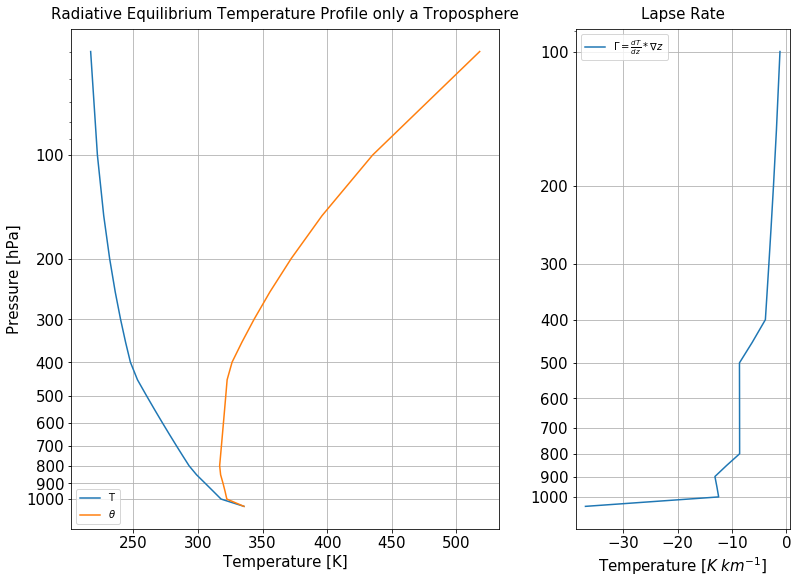

In [7]:
# plotting
fig = plt.figure(figsize=(11,8),constrained_layout=True)
gs1 = gs.GridSpec(2,3,figure=fig)

ax1 = fig.add_subplot(gs1[0:,0:2])
plt.plot(T[:,-1],plev[:],label='T')
plt.plot(theta[:,-1],plev[:],label=r'$\theta$')
ax1.invert_yaxis(); plt.yscale('log')
plt.grid()
plt.yticks(plev[1::2], [str(int(val/100)) for val in plev[1::2]]);
plt.xlabel('Temperature [K]');
plt.ylabel('Pressure [hPa]');
plt.title('Radiative Equilibrium Temperature Profile only a Troposphere')
plt.legend();

ax2 = fig.add_subplot(gs1[0:,2:])
plt.title('Lapse Rate')
plt.plot(lapse_rate[:],plev[0:-1],label =r'$\Gamma = \frac{dT}{dz}*\nabla z$')
ax2.invert_yaxis(); plt.yscale('log')
plt.grid();
plt.legend();
plt.yticks(plev[1::2], [str(int(val/100)) for val in plev[1::2]]);
plt.xlabel(r'Temperature [$K \; km^{-1}$]');

### Part b) Addition of a Stratosphere

In [8]:
# len(t) = 100_000_000 seconds ~3.5 yrs

tic()
dt = 60*60 # every hour

# time loop
for i in np.arange(0,len(t)-1):
#     print(f"Time: {i}")
# for i in [24]:
    
    
    # upward LW stream
    for j in np.arange(0,len(plev)):
        if j==0:
            emi_out = epsilon[j]*sigma*(T_strat[j,i]**4)
#             print(emi_out)
            emi_in = 0
            trans = 0
            absorption = 0
            lw_up_bot[j,i] = 0
            lw_up_top[j,i] = emi_out + trans
#             print(f)
        else: # for 1,...,20
            emi_out = epsilon[j]*sigma*(T_strat[j,i]**4)
#             print(emi_out)
            emi_in = epsilon[j-1]*sigma*(T_strat[j-1,i]**4)
            f_up[j,i] = emi_in + trans
            trans = (1-epsilon[j])*f_up[j,i]
#             lw_up_bot[j,i] = emi_in
            lw_up_bot[j,i] = f_up[j,i]

            lw_up_top[j,i] = emi_out + trans
#             print(f)
    # downward LW stream
    for j in np.arange(len(plev)-1,-1,-1): # correct index for layer 20 is len(plev)-1
#         print(j)
        if j==20: # layer 20 (last atm layer)
            emi_out = epsilon[j]*sigma*(T_strat[j,i]**4)
            emi_in = 0
            trans = 0
            lw_down_bot[j,i] = emi_out + trans
            lw_down_top[j,i] = 0
        elif j==0:
            lw_down_top[j,i] = emi_out + trans
            lw_down_bot[j,i] = 0
        else: # 19,18,...,0
            emi_out = epsilon[j]*sigma*(T_strat[j,i]**4)
            emi_in = epsilon[j+1]*sigma*(T_strat[j+1,i]**4)
            f_down[j,i] = emi_in + trans

            lw_down_top[j,i] = emi_in + trans
            trans = (1-epsilon[j])*f_down[j,i]
            lw_down_bot[j,i] = emi_out + trans

    # downward SW stream
    for j in np.arange(len(plev)-1,-1,-1):
        if j==0:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_bot[j,i] = 0 

        elif j==20:
            sw_down_top[j,i] = (So/4)*(1-a)
            sw_down_abs = 0.05*((So/4)*(1-a))
            sw_down_bot[j,i] = 0.95*(So/4)*(1-a)
            
        elif j==19:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.025*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.025)*sw_down_top[j,i]
            
        elif j==18:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.0125*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.0125)*sw_down_top[j,i]
            
        elif j==17:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.00625*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.00625)*sw_down_top[j,i]
            
        elif j==16:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_abs = 0.003125*sw_down_top[j,i]
            sw_down_bot[j,i] = (1-0.003125)*sw_down_top[j,i]
        else:
            sw_down_top[j,i] = sw_down_bot[j+1,i]
            sw_down_bot[j,i] = sw_down_bot[j+1,i]          
            
    # calculate (broadcast) net radiation in each layer for time step i
    dF[:,i] = lw_up_bot[:,i] - lw_up_top[:,i] + lw_down_top[:,i] \
    - lw_down_bot[:,i] + sw_down_top[:,i] - sw_down_bot[:,i]
    
    # calculate temperature array
    T_strat[:,i+1] = T_strat[:,i] + dF[:,i]/(m*cp)*dt

toc()

Elapsed time is 20.080602169036865 seconds.


In [9]:
# calculate potential temperature
theta_strat = np.zeros([np.size(plev),np.size(t)])
for i in np.arange(0,len(t)):
    theta_strat[:,i] = T_strat[:,i]*((np.ones(21)*105000)/(plev[:]))**(0.286)

# calculate lapse rate
Rd = 287
g = 9.8
lapse_rate_strat = np.zeros(20)

dz = np.zeros([np.size(plev),np.size(t)])
for i in np.arange(0,np.size(plev)-1):
    dz = ((Rd*T_strat[i,-1])/g)*np.log(plev[i]/plev[i+1])
    lapse_rate_strat[i] = (T_strat[i+1,-1]-T_strat[i,-1])/dz*1000


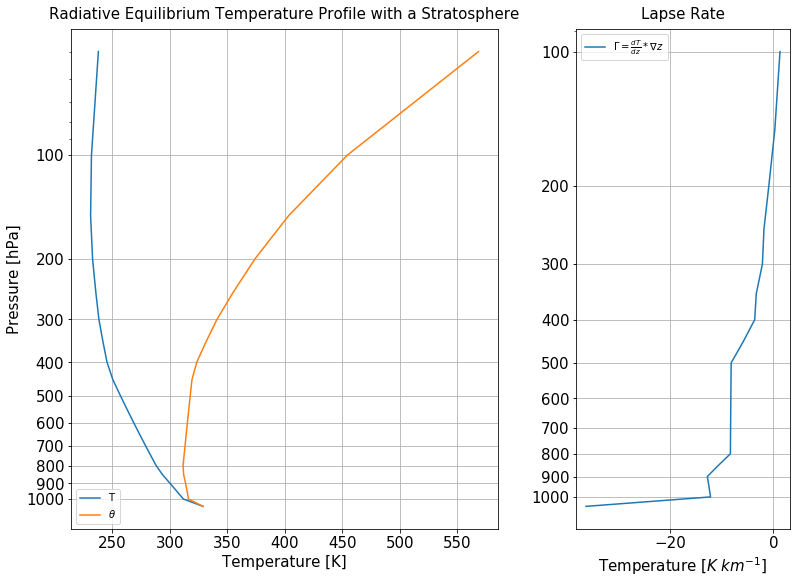

In [10]:
# plotting
fig = plt.figure(figsize=(11,8),constrained_layout=True)
gs1 = gs.GridSpec(2,3,figure=fig)

ax1 = fig.add_subplot(gs1[0:,0:2])
plt.plot(T_strat[:,-1],plev[:],label='T')
plt.plot(theta_strat[:,-1],plev[:],label=r'$\theta$')
ax1.invert_yaxis(); plt.yscale('log')
plt.grid()
plt.yticks(plev[1::2], [str(int(val/100)) for val in plev[1::2]]);
plt.xlabel('Temperature [K]');
plt.ylabel('Pressure [hPa]');
plt.title('Radiative Equilibrium Temperature Profile with a Stratosphere')
plt.legend();

ax2 = fig.add_subplot(gs1[0:,2:])
plt.title('Lapse Rate')
plt.plot(lapse_rate_strat[:],plev[0:-1],label =r'$\Gamma = \frac{dT}{dz}*\nabla z$')
ax2.invert_yaxis(); plt.yscale('log')
plt.grid();
plt.legend();
plt.yticks(plev[1::2], [str(int(val/100)) for val in plev[1::2]]);
plt.xlabel(r'Temperature [$K \; km^{-1}$]');

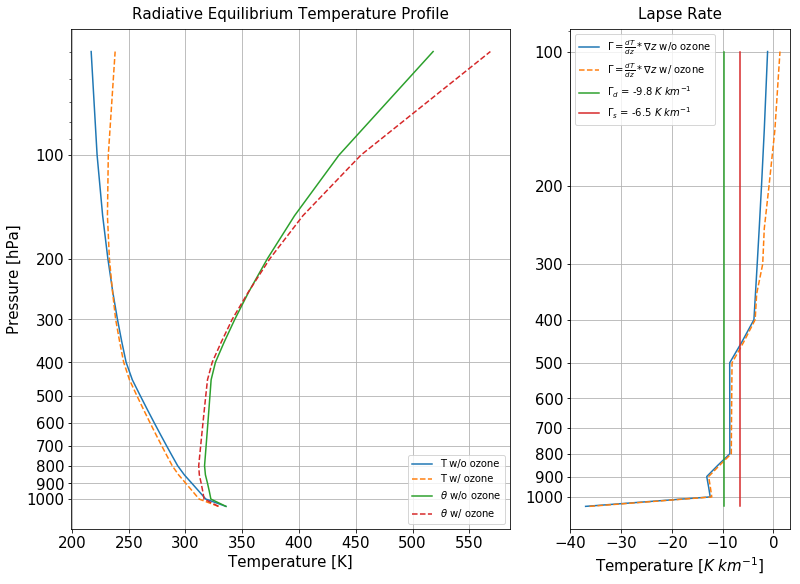

In [11]:
### Plot both together
# plotting
fig = plt.figure(figsize=(11,8),constrained_layout=True)
gs1 = gs.GridSpec(2,3,figure=fig)

ax1 = fig.add_subplot(gs1[0:,0:2])
plt.plot(T[:,-1],plev[:],label='T w/o ozone')
plt.plot(T_strat[:,-1],plev[:],linestyle='--',label='T w/ ozone')

plt.plot(theta[:,-1],plev[:],label=r'$\theta$ w/o ozone')
plt.plot(theta_strat[:,-1],plev[:],linestyle='--',label=r'$\theta$ w/ ozone')
ax1.invert_yaxis(); plt.yscale('log')
plt.grid()
plt.yticks(plev[1::2], [str(int(val/100)) for val in plev[1::2]]);
plt.xlabel('Temperature [K]');
plt.ylabel('Pressure [hPa]');
plt.title('Radiative Equilibrium Temperature Profile')
plt.legend();

ax2 = fig.add_subplot(gs1[0:,2:])
plt.title('Lapse Rate')
plt.plot(lapse_rate[:],plev[0:-1],label =r'$\Gamma = \frac{dT}{dz}*\nabla z$ w/o ozone')
plt.plot(lapse_rate_strat[:],plev[0:-1],linestyle='--',label =r'$\Gamma = \frac{dT}{dz}*\nabla z$ w/ ozone')
plt.plot(np.ones(20)*-9.8,plev[0:-1],label=r'$\Gamma_d$ = -9.8 $K\;km^{-1}$')
plt.plot(np.ones(20)*-6.5,plev[0:-1],label=r'$\Gamma_s$ = -6.5 $K\;km^{-1}$')
ax2.invert_yaxis(); plt.yscale('log')
plt.grid(); 
plt.legend(prop={'size':10});
plt.yticks(plev[1::2], [str(int(val/100)) for val in plev[1::2]]);
plt.xticks(np.arange(-40,5,10))
plt.xlabel(r'Temperature [$K \; km^{-1}$]');

**a) Comment on the stability of the atmosphere:**
- I see three regimes, where $\theta$ decreases with height (surface to 800hPa), $\theta$ remains approximately  constant with height (700hPa to 450hPa) and where $\theta$ increases with height (450hPa to TOA). Looking at the lapse rate profiles, we can identify layers of different stabilites. The atmosphere is absolutely unstable near the surface at 1050hPa to ~825hPa because $\Gamma_{env}$ is greater than the dry lapse rate $\Gamma_d$, thus a dry parcel will cool slower than its environment and thus will always be warmer than its surroundings leading to unstable convection. The atmosphere is conditionally unstable from ~825hPa to ~450hPa, with $\Gamma_{s}$ < $\Gamma_{env}$ < $\Gamma_{d}$, thus a dry parcel will be negatively buoyant and sink, and a moist parcel will be positively buoyant and rise. From ~450hPa to the the top of the atmosphere, this layer is absolutely stable because $\Gamma_{env}$ < $\Gamma_{s}$, thus both moist and dry parcels will always sink in this layer.

**b) Addition of a stratosphere:**
- With the addition of ozone, the temperature starts off a little cooler at the surface and warms past the tropopause and stratosphere (~>250mb) as compared to the temperature profile without ozone. Similarly, the potential temperature with ozone starts off cooler at the surface and warmer in the stratosphere than the potential tempearture profile without ozone.
- Here we are simulating the existence of ozone in the stratosphere where the input of "ozone" tends to warm the stratosphere (in reality through interaction of UV radiation, splitting of O2 molecules to form ozone). Rather what is happening in the model is there is a positive net flux of SW into the top 5 layers where the bottom 15 are fully transmissive to SW (excluding the surface). I think the slight difference in temperature near the bottom is due to the conservation of energy. Since we have a constant energy input at the top of the atmosphere where the top is warming more with ozone, the bottom layers receive less radiant flux due to conservation of energy and are slightly cooler.